# Medium optimization

## Carbon source assessment 
Author: 
`Haroun Bensaadi`

In [237]:
from cobra.io import read_sbml_model
import pandas as pd
import matplotlib.pyplot as plt

model = read_sbml_model('Files/iCGB21FR_updated.xml')

In [228]:
model.medium

{'EX_glc__D_e': 10.0,
 'EX_h2o_e': 10.0,
 'EX_h_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_nh4_e': 10.0,
 'EX_fe3_e': 10.0,
 'EX_k_e': 10.0,
 'EX_ca2_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_mn2_e': 10.0,
 'EX_zn2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_o2_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_so4_e': 10.0,
 'EX_urea_e': 10.0,
 'EX_btn_e': 10.0,
 'EX_na1_e': 10.0,
 'EX_ni2_e': 10.0,
 'EX_34dhbz_e': 10.0}

In [230]:
print(f"Carbon sources in the medium are:")

for medium_component in model.medium:
    for metabolite in model.reactions.get_by_id(medium_component).metabolites:
        if 'C' in metabolite.elements:
            print(f" - {model.metabolites.get_by_id(metabolite.id).name}")
       


Carbon sources in the medium are:
 - D-Glucose
 - Urea
 - Biotin
 - 3,4-Dihydroxybenzoate


**The default medium of the model comes with 4 carbon sources, however glucose acts as the main carbon source**

### Getting a list of all possible carbon sources that can be added to the medium

In [238]:
carbon_sources = []

for reaction in model.reactions:
    if "EX_" in reaction.id:
        for metabolite in reaction.metabolites:
            if 'C' in metabolite.elements:
                carbon_sources.append(reaction)

print(f"Number of found carbon sources: {len(carbon_sources)}\n")
       
carbon_source_names = [model.metabolites.get_by_id(carbon_source.reactants[0].id).name for carbon_source in carbon_sources]
print_string = ", ".join(carbon_source_names)
print(print_string)

Number of found carbon sources: 153

D-Glucose, 2-Phosphoglycolate, L-Leucine, 3-Methylbutanoic acid, L-alanine-D-glutamate-meso-2,6-diaminoheptanedioate, L-Alanine, L-alanine-D-glutamate-meso-2,6-diaminoheptanedioate-D-alanine, 5-Dehydro-D-gluconate, 5-Methylthio-D-ribose, L-Arabinose, L Arabinitol C5H12O5, 4-Aminobutanoate, Acetoacetate, N-Acetyl-D-glucosamine, Choline, N-Acetyl-D-mannosamine,  R  Acetoin C4H8O2, Acetyl-cystine-bimane, Adenine, 2-Oxoglutarate, L-Malate, D-Alanyl-D-alanine, D-Alanine, L-Glutamine, Glycine, L-Serine, L-Threonine, L-Arginine, Cys-Gly, Maltose, Maltotriose, Starch n=1200 repeat units (300 repeat units amylose, 900 repeat units amylopectin, corresponds to potatoe starch), Amylose (n=300 repeat units, alpha-1,4-glc), N-Acetyl-D-glucosamine(anhydrous)N-Acetylmuramic acid, D Arabinose C5H10O5, L-Lysine, Ornithine, L-Aspartate, L-Proline, Beta-Alanine, Cellobiose, Methanol, Alpha Methyl D glucoside C7H14O6, Beta Methylglucoside C7H14O6, Bimane, Butanesulfonat

### 1. Effect of the carbon source on growth
- The growth is not limited, thus taking its max value of 0.57066 [1/h]
- The objective function is growth
- Each time, glucose is removed and replaced with one carbon source.

In [256]:
%%capture

solutions_growth = {}

threshold_growth = 0.57066

# creating every time a new medium without glucose and with the carbon source
for carbon_source in carbon_sources:
    with model:
        
        medium = model.medium
        medium['EX_glc__D_e'] = 0
        medium[carbon_source.id] = 10
        model.medium = medium
        
        model.reactions.Growth.bounds = (0, 1000)
        model.objective = model.reactions.Growth
        solution = model.optimize()
        
        if solution["Growth"] > threshold_growth+0.00001 or carbon_source.id == "EX_glc__D_e":
            compound_name = model.metabolites.get_by_id(carbon_source.reactants[0].id).name
            
            compound_name = "D-Glucose (default)" if compound_name == "D-Glucose" else compound_name
            compound_name = "Starch" if compound_name == "Starch n=1200 repeat units (300 repeat units amylose, 900 repeat units amylopectin, corresponds to potatoe starch)" else compound_name
            compound_name = "Glycogen" if compound_name == "Glycogen (n=1500 repeat units) (glc alpha 1,4/6 glc)" else compound_name
            compound_name = "Amylose" if compound_name == "Amylose (n=300 repeat units, alpha-1,4-glc)" else compound_name
            compound_name = "Raffinose" if compound_name == "Raffinose C18H32O16" else compound_name

            solutions_growth[compound_name] = {"growth": solution["Growth"], "lysine": solution["DAPDC"]}


In [257]:
df_growth = pd.DataFrame([(compound, data['growth'], data['lysine']) for compound, data in solutions_growth.items()],
                         columns=['Compound', 'Growth [1/h]', 'Lysine [mmol/gDW*h]'])

df_growth = df_growth.sort_values(by='Growth [1/h]', ascending=True).reset_index(drop=True)
df_growth

,Compound,Growth [1/h],Lysine [mmol/gDW*h]
0,D-Glucose (default),0.570660,0.189644
1,D-Glucosamine,0.571343,0.189871
2,Raffinose,0.789777,0.262462
3,Trehalose,0.843681,0.280375
4,Sucrose,0.843681,0.280375
5,Cellobiose,0.843681,0.280375
6,Maltose,0.843681,0.280375
7,Maltotriose,1.088968,0.361890
8,Maltotetraose,1.246319,0.414181
9,Maltopentaose,1.530495,0.508620


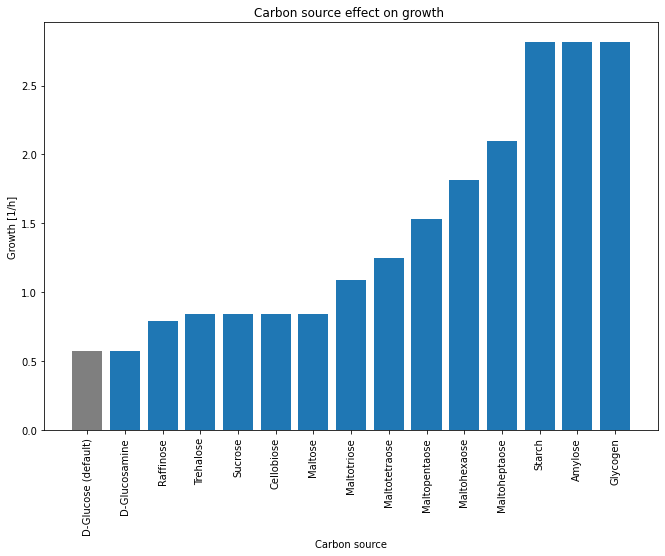

In [258]:
plt.figure(figsize=(11, 7.5))  
plt.bar(df_growth['Compound'], df_growth['Growth [1/h]'])
plt.bar(df_growth['Compound'], df_growth['Growth [1/h]'], color=['tab:gray' if compound == 'D-Glucose (default)' else 'tab:blue' for compound in df_growth['Compound']])

plt.title('Carbon source effect on growth ')
plt.xlabel('Carbon source')
plt.xticks(rotation=90)
plt.ylabel('Growth [1/h]')
plt.show()

### Analysis
**Replacing glucose with other carbon sources yielded better growth rate** 

### Scenario 2: effect of the carbon source on lysine production
- The growth is limited to 0.259194 [1/h]
- The objective function is lysine flux
- Each time, glucose is removed and replaced with one carbon source.

In [259]:
%%capture

solutions_lysine = {}

threshold_lysine = 6.397161

# creating every time a new medium without glucose and with the carbon source
for carbon_source in carbon_sources:
    with model:
        
        medium = model.medium
        medium['EX_glc__D_e'] = 0
        medium[carbon_source.id] = 10
        model.medium = medium
        
        model.reactions.Growth.bounds = (0.259194, 1000)
        model.objective = model.reactions.DAPDC
        solution = model.optimize()

        if solution["DAPDC"] > threshold_lysine+0.00001 or carbon_source.id == "EX_glc__D_e":
            compound_name = model.metabolites.get_by_id(carbon_source.reactants[0].id).name
            
            compound_name = "D-Glucose (default)" if compound_name == "D-Glucose" else compound_name
            compound_name = "Starch" if compound_name == "Starch n=1200 repeat units (300 repeat units amylose, 900 repeat units amylopectin, corresponds to potatoe starch)" else compound_name
            compound_name = "Glycogen" if compound_name == "Glycogen (n=1500 repeat units) (glc alpha 1,4/6 glc)" else compound_name
            compound_name = "Amylose" if compound_name == "Amylose (n=300 repeat units, alpha-1,4-glc)" else compound_name
            compound_name = "Raffinose" if compound_name == "Raffinose C18H32O16" else compound_name

            solutions_lysine[compound_name] = {"growth": solution["Growth"], "lysine": solution["DAPDC"]}


In [260]:
df_lysine = pd.DataFrame([(compound, data['growth'], data['lysine']) for compound, data in solutions_lysine.items()],
                         columns=['Compound', 'Growth [1/h]', 'Lysine [mmol/gDW*h]'])

df_lysine = df_lysine.sort_values(by='Lysine [mmol/gDW*h]', ascending=True).reset_index(drop=True)
df_lysine


,Compound,Growth [1/h],Lysine [mmol/gDW*h]
0,D-Glucose (default),0.259194,6.397157
1,D-Glucosamine,0.259194,6.929089
2,Raffinose,0.259194,9.729807
3,Sucrose,0.259194,10.480531
4,Cellobiose,0.259194,10.480531
5,Trehalose,0.259194,10.480531
6,Maltose,0.259194,10.480531
7,Maltotriose,0.259194,13.638426
8,Starch,0.259194,13.706651
9,Maltoheptaose,0.259194,13.706651


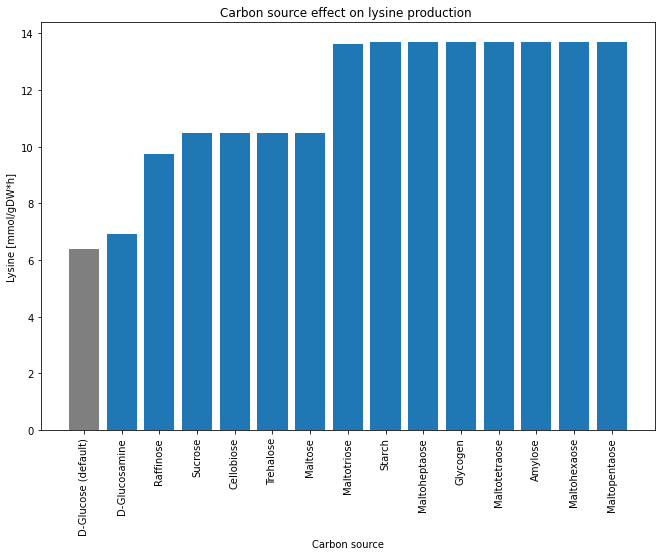

In [261]:
plt.figure(figsize=(11, 7.5))  
plt.bar(df_lysine['Compound'], df_lysine['Lysine [mmol/gDW*h]'])
plt.bar(df_lysine['Compound'], df_lysine['Lysine [mmol/gDW*h]'], color=['tab:gray' if compound == 'D-Glucose (default)' else 'tab:blue' for compound in df_growth['Compound']])

plt.title('Carbon source effect on lysine production ')
plt.xlabel('Carbon source')
plt.xticks(rotation=90)
plt.ylabel('Lysine [mmol/gDW*h]')
plt.show()

### Analysis
**Replacing glucose with other carbon sources yielded better lysine production** 